In [ ]:
# min, max of density from fast_kde is not correct
# https://github.com/yixuan/fastncdf make cdf computation faster

In [63]:
import numpy as np
import multiprocessing as mp
from functools import partial
import math
import pandas as pd
from helpers_trans import Fy, imgs_input_fn,  multivariate_normal, find_closest_element, predict_density, bring_df_to_correct_format
import helpers_trans as hlp
from random import  uniform
import scipy.stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed

In [3]:
# p = number of betas
p = 10

Read in 
- $\vartheta$, 
- KDE densities $p_y(y_i)$, 
- DNN model $f: x \rightarrow y$, 
- true $y$ values

In [4]:
extracted_coefficients_directory = '../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
y_path = str(extracted_coefficients_directory + 'Bzeta/labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
true_z = np.load(z_path)
true_y = np.load(y_path)

# filtered Ridge 
va_ridge_dir = '../../data/commaai/va/filtered_gaussian_resampled/Ridge/'
mu_t_va = np.genfromtxt(va_ridge_dir + 'mu_t_va.csv', delimiter = ',')
beta = np.mean(mu_t_va[int(0.9*50000):50000,0:10], axis = 0)
tau_sq = np.exp(np.mean(mu_t_va[int(0.9*50000):50000,10], axis = 0))
#vartheta_path = '../../data/density/03082020/vartheta_final.csv'
#B_zeta_path = '../../bdd100k_test_data/extracted_coefficients/10092020/B_zeta_predictions_val.csv'
#z_path = '../../data/tfrecords/03082020/val_yaw_transformed.csv'
density_path = '../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)
#true_y_path = '../../data/tfrecords/03082020/val_yaw_original.csv'


#vartheta = np.genfromtxt(vartheta_path, delimiter=',')
#B_zeta = np.genfromtxt(B_zeta_path, delimiter=',')
n = B_zeta.shape[0]
#true_z = np.genfromtxt(z_path, delimiter=',')[:n]
#density = pd.read_csv(density_path)
#true_y = np.genfromtxt(true_y_path, delimiter=',')[:n]

# Get predictions for new observations B_zeta from different file
# for convenience

We want to compute the following density value

\\[\hat{p}_0(y_0 | x_0) = \frac{p_Y(y_0)}{\phi_1(\Phi_1^{-1}(F_Y(y_0)))} \frac{1}{\hat{s_0}} \phi_1 \Big( \frac{\Phi_1^{-1}(F_Y(y_0)) - \hat{s_0}\hat{f}_{\eta}(x_0)}{\hat{s_0}} \Big),  \\]
where $\hat{f}_{\eta}(x_0) = \psi_{\zeta}(x_0)^T\hat{\beta}$, $\hat{s}_0 = (1 + \psi_{\zeta}(x_0)^T P(\hat{\theta})^{-1}\psi_{\zeta}(x_0))^{\frac{1}{2}}$

So $y_0$ can also be a new value i think -> can predict whole density curve for new observations
Apparently this method only predicts posterior densities for realizations of y. 
For example, we could train our model, then get posterior densities for a test set and inspect the densities. 
If the densities have several modes -> can say that our model is too unsure about its predictions.
Can also say what the confidence intervals of our predictions are.
We can obtain uncertainty of the predictions itself with Mixture density networks for example (nice comparison - weight uncertainty (Bayes by Backprop), prediction uncertainty (MDN), target uncertainty (Klein). However, Klein does rely on parametric assumptions, which the other two do not (disadvantage, may introduce bias).

## Posterior densities at true values
evaluating the posterior densities at the true, realized values

In [5]:
def density_at_true_value(density, true_y, true_z, B_zeta, tau_sq, beta_t):
    
    axes = np.array(density['axes'])
    p_y_y0 = [density.loc[find_closest_element(y_i,density['axes'])]['pdf']  for y_i in true_y]
    
    f_eta_x0 = B_zeta.dot(beta_t)
    s_0_hat = np.sqrt(1 + tau_sq*np.array([B_zeta[j,:].T.dot(B_zeta[j,:]) for j in range(0,n)]))
    phi_1_z = np.array([scipy.stats.norm(0, 1).pdf(z_i) for z_i in true_z])
    term_1 = (true_z - s_0_hat*f_eta_x0)/(s_0_hat)
    term_2 = np.array([scipy.stats.norm(0, 1).pdf(z_i) for z_i in term_1])
    p_y0_x0 = (p_y_y0/phi_1_z)*(1/s_0_hat)*term_2
    
    return p_y0_x0

In [6]:
true_densities = hlp.density_at_true_value(density, true_y, true_z, B_zeta, tau_sq, beta)

KeyboardInterrupt: 

In [ ]:
plt.scatter(true_y, true_densities, alpha = 0.25, s = 1.5)
plt.title('Predictive density at true, observed y values')

## Posterior values at new covariates

In [ ]:
# This should be faster... (ultra fast)
# ideas:
# precompute values that we can use for one y_i
# compute all the cdf and pdf values in parallel
# maybe even get density values from density estimation only?
# then predict values together

In [53]:
len(true_y)

43736

In [54]:
ind = range(0, len(true_y))#(abs(true_y) > 15)
ind_large = [i for i, x in enumerate(ind) if x]

In [55]:
sample_index = ind_large[0:500] #range(0, 100)#B_zeta.shape[0])
psi_x0 = np.array([B_zeta[i,:] for i in sample_index])
grid = np.linspace(min(density['axes']), max(density['axes']), 10000)

In [56]:
density_y = density['axes']
density_pdf = density['pdf']
# compute these beforehand to save computation time
p_y_y0 = [density_pdf[find_closest_element(y_i,density_y)] for y_i in grid]
part_1 = np.array([norm.ppf(Fy(y_i, density)) for y_i in grid])
phi_1_z = np.array([scipy.stats.norm(0, 1).pdf(y_i) for y_i in part_1])

In [57]:
def predict_density(x, grid, p_y_y0, part_1, phi_1_z, beta, tau_sq):
    
    psi_x0 = x
    
    f_eta_x0 = psi_x0.dot(beta)
    s_0_hat = (1 + tau_sq*psi_x0.dot(psi_x0))**(-0.5)
    
    part_0 = s_0_hat*f_eta_x0

    # compute the cdf of new ys
    
    term_1 = scipy.stats.norm(0, 1).pdf((part_1- part_0) / s_0_hat)

    p_y_single_obs_whole_dens = (p_y_y0/phi_1_z)*(1/s_0_hat)*term_1
    
    return(p_y_single_obs_whole_dens)

In [58]:
result = [predict_density(B_zeta[i,:], grid, p_y_y0, part_1, phi_1_z, beta, tau_sq) for i in sample_index]

In [59]:
df = pd.DataFrame(result)

In [60]:
df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,3.144042e-09,4.913835e-09,5.696933e-09,6.591027e-09,7.463015e-09,8.678660e-09,9.934672e-09,1.169790e-08,1.350344e-08,1.600312e-08,...,2.196738e-05,1.923092e-05,1.720647e-05,1.519635e-05,1.375888e-05,1.239921e-05,1.149751e-05,1.075266e-05,1.039859e-05,1.045975e-05
1,2.270749e-11,5.360072e-11,6.963394e-11,8.773578e-11,1.049972e-10,1.288298e-10,1.535316e-10,1.886593e-10,2.253121e-10,2.772386e-10,...,2.509533e-05,2.174933e-05,1.928083e-05,1.682937e-05,1.506676e-05,1.337202e-05,1.220159e-05,1.112272e-05,1.037300e-05,9.279428e-06
2,4.423234e-11,9.749782e-11,1.243095e-10,1.544474e-10,1.831666e-10,2.227809e-10,2.637598e-10,3.218640e-10,3.822762e-10,4.675183e-10,...,3.208074e-05,2.792927e-05,2.486144e-05,2.181333e-05,1.962516e-05,1.753324e-05,1.610917e-05,1.484428e-05,1.405330e-05,1.317206e-05
3,3.031610e-08,3.966517e-08,4.377590e-08,4.880761e-08,5.395289e-08,6.129580e-08,6.894952e-08,7.969384e-08,9.064231e-08,1.056783e-07,...,1.431810e-05,1.254542e-05,1.123422e-05,9.933000e-06,9.003635e-06,8.127074e-06,7.549686e-06,7.082250e-06,6.881297e-06,7.043860e-06
4,3.539067e-08,4.582441e-08,5.042618e-08,5.609889e-08,6.192410e-08,7.025405e-08,7.894367e-08,9.114396e-08,1.035734e-07,1.206358e-07,...,1.330659e-05,1.165421e-05,1.043218e-05,9.219494e-06,8.353190e-06,7.535552e-06,6.996013e-06,6.556873e-06,6.363034e-06,6.490578e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.721852e-06,2.606154e-06,2.635590e-06,2.751284e-06,2.913616e-06,3.174938e-06,3.461062e-06,3.869249e-06,4.285147e-06,4.850880e-06,...,1.270430e-06,1.098438e-06,9.719461e-07,8.466836e-07,7.568631e-07,6.707440e-07,6.115026e-07,5.573970e-07,5.210785e-07,4.774690e-07
496,4.740873e-07,5.050851e-07,5.264540e-07,5.622699e-07,6.044061e-07,6.682729e-07,7.365359e-07,8.330742e-07,9.312854e-07,1.065216e-06,...,5.472876e-06,4.780729e-06,4.269543e-06,3.762586e-06,3.400228e-06,3.057193e-06,2.828928e-06,2.638496e-06,2.544826e-06,2.557395e-06
497,1.420355e-05,1.390735e-05,1.410893e-05,1.474976e-05,1.562812e-05,1.703277e-05,1.856619e-05,2.074971e-05,2.297115e-05,2.598857e-05,...,3.534690e-09,2.896946e-09,2.442050e-09,2.001772e-09,1.689547e-09,1.386863e-09,1.168019e-09,9.412564e-10,7.428941e-10,4.081062e-10
498,2.608496e-07,2.893054e-07,3.049631e-07,3.284905e-07,3.550691e-07,3.947099e-07,4.367965e-07,4.961813e-07,5.565900e-07,6.390663e-07,...,7.730585e-06,6.766859e-06,6.054539e-06,5.347999e-06,4.843447e-06,4.367320e-06,4.053124e-06,3.797363e-06,3.684887e-06,3.768893e-06


In [61]:
average_pred_density = df.mean(axis=0)

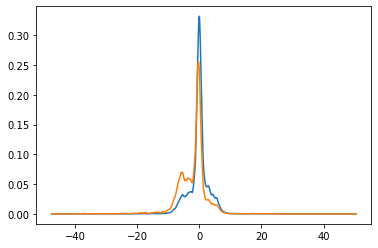

In [62]:
plt.plot(density['axes'], density['pdf'], label = 'fast (= true) KDE')
plt.plot(grid, average_pred_density)

In [ ]:
density['axes'].shape

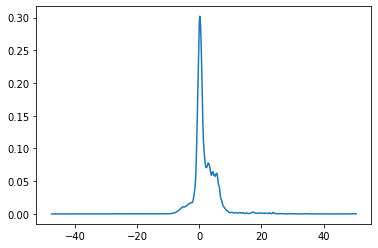

In [51]:
plt.figure()
for i in range(0,1):
    plt.plot(grid, df.iloc[52,:] )
plt.show()

In [ ]:
plt.plot(grid, df.iloc[1,:] )

In [ ]:
true_y[ind_large[0]]

In [ ]:
df.plot.line(linewidth = 0.05)
plt.plot(df.index, df['average_pred_density'], label = 'average predictive density')
plt.plot(density['axes'], density['pdf'], label = 'fast (= true) KDE')
plt.title('Marginal calibration of predictive densities')
#plt.legend()
plt.show()

In [ ]:
df = bring_df_to_correct_format(result, grid)
df['average_pred_density'] = df.mean(axis=1)
df.to_csv('look_at_densities.csv')

In [ ]:
'''predict_density_part = partial(predict_density, grid, 
                               density_y, density_pdf,
                               beta_t, Lambda_t_sq)
num_cores = mp.cpu_count()
pool = mp.Pool(processes=num_cores)
Fy_y = pool.map(predict_density_part, psi_x0)'''

In [ ]:
'''num_cores = multiprocessing.cpu_count()
grid = np.linspace(min(density['y']), max(density['y']), 1000)'''

In [ ]:
'''def predict_density(grid, density, psi_x0, beta_t, Lambda_t):
    
    #Predicts density for a new observation with the copula
    #model
    #Input: df with columns:
    #       grid, density, psi_x0, beta_t, Lambda_t
    #Output: density at grid
    
    # compute p_Y(y_0) for each y in grid
    axes = np.array(density['y'])
    p_y_y0 = [density.loc[find_closest_element(y_i,density['y'])]['pdf']  for y_i in grid]
    
    f_eta_x0 = psi_x0.dot(beta_t)
    s_0_hat = math.sqrt(1 + psi_x0.dot(Lambda_t).dot(psi_x0))
    
    part_0 = s_0_hat*f_eta_x0
    part_1 = np.array([norm.ppf(Fy(y_i, density)) for y_i in grid])
    # here occur some issues with values of -inf
    # fix invalid values later ...
    #part_1[np.isinf(part_1)] = 0.01
    
    # compute the cdf of new ys
    phi_1_z = np.array([scipy.stats.norm(0, 1).pdf(y_i) for y_i in part_1])
    
    term_1 = scipy.stats.norm(0, 1).pdf((part_1- part_0) / s_0_hat)

    p_y_single_obs_whole_dens = (p_y_y0/phi_1_z)*(1/s_0_hat)*term_1
    return(p_y_single_obs_whole_dens)'''

In [ ]:
'''num_cores = mp.cpu_count()
pool = mp.Pool(processes=num_cores)
prod_x = partial(predict_density, df = density)'''

In [ ]:
'''Fy_y = pool.map(prod_x, density.dens)'''

In [ ]:
'''sample_index = [int(uniform(0, 2600)) for i in range(0,2000)]
result = Parallel(n_jobs=num_cores)(delayed(predict_density(grid = grid, 
                                                            density = density, 
                                                            psi_x0 = B_zeta[i,:], 
                                                            beta_t = beta_t, 
                                                            Lambda_t = Lambda_t_sq)) for i in sample_index)'''

In [ ]:
df = bring_df_to_correct_format(result)
df['average_pred_density'] = df.mean(axis=1)
df.to_csv('look_at_densities.csv')

In [ ]:
grid = np.linspace(min(density['axes']), max(density['axes']), 1000)

In [ ]:
#result = [predict_density(y = true_y[i], z = true_z[i], grid = grid, density = density, psi_x0 = B_zeta[i,:], beta_t = beta_t, Lambda_t = Lambda_t_sq) for i in sample_index]
df = bring_df_to_correct_format(result, grid)
df['average_pred_density'] = df.mean(axis=1)

In [ ]:
result

In [ ]:
df.to_csv('look_at_densities.csv')

## Average predicted density
\\[ \hat{p}_Y(y_i|x_i) \\]

In [ ]:
s.plot.line(linewidth = 0.05)
plt.plot(s.index, s['average_pred_density'], label = 'average predictive density')
plt.plot(density['axes'], density['pdf'], label = 'fast (= true) KDE')
plt.title('Marginal calibration of predictive densities')
plt.legend()
plt.show()

In [ ]:
plt.savefig('density_pred.png')

## Density predictions for training observations

\\[ p(y |x, \beta, \theta) = p(z | x, \beta, \theta) \prod_{i=1}^n \frac{p_Y(y_i)}{\phi_1(z_i)} = \phi_n(z; S(x,\theta)B_{\zeta}(x)\beta, S(x,\theta)^2)\prod_{i=1}^n \frac{p_Y(y_i)}{\phi_1(z_i)} \\]

This density evaluates to 0 ... bc of the product in the end. Is this correct or should there really be a density value?

In [ ]:
axes = np.array(density['axes'])
p_y_y0_closest_element = [find_closest_element(y_i,axes ) for y_i in true_z]
p_y_y0 = [density[density['axes'] == closest_i]['pdf'].to_numpy()  for closest_i in p_y_y0_closest_element]
p_y_y0 = [item for sublist in p_y_y0 for item in sublist]

In [ ]:
phi_1_z = [scipy.stats.norm(0, 1).pdf(y_i) for y_i in true_z]

In [ ]:
any([i == 0 for i in p_y_y0])

In [ ]:
np.prod(phi_1_z)

In [ ]:
np.sum(np.log(np.array(p_y_y0)/np.array(phi_1_z)))

In [ ]:
np.prod(np.array(p_y_y0)/np.array(phi_1_z))

In [ ]:
mean = S.dot(B_zeta.dot(beta))
cov = S**2
part_1 = [multivariate_normal(z_i, n, mean, covariance) for z_i in true_z]
part_2 = np.prod([pdf_y(y_i, density) for y_i in true_y])
part_3 = np.prod([multivariate_normal(z_i, 1, 0, 1) for z_i in true_z ])
p_y_cond_x_beta_theta = pdf_y*part_2/part_3
# need to evaluate this for every y there is to get the whole probability distribution
# and plot it